In [1]:
# Import necessary modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import optuna
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, RocCurveDisplay)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# XGBoost import
import xgboost as xgb

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

### LOAD AND CHECK DATA

In [2]:
# Load the data
airline_data = pd.read_csv(r"C:\Users\YILMAZ\Desktop\final_airplane_data.csv")

In [3]:
# Dataset Info
print(f"Shape: {airline_data.shape}")
print(f"Columns: {list(airline_data.columns)}")

Shape: (119255, 22)
Columns: ['satisfaction', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding', 'Departure Delay Winsorized', 'Arrival Delay Winsorized']


In [4]:
# Data Types
airline_data.dtypes

satisfaction                          object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay Winsorized             int64
Arrival Delay Winsorized             float64
dtype: obj

In [5]:
# First rows
airline_data.head()

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay Winsorized,Arrival Delay Winsorized
0,dissatisfied,Loyal Customer,48,Personal Travel,Eco,4001,1,1,1,1,1,1,1,1,4,1,1,4,2,1,16,0.000
1,dissatisfied,Loyal Customer,48,Personal Travel,Eco,3980,1,1,1,1,4,1,4,4,2,3,2,3,2,4,0,0.000
2,dissatisfied,Loyal Customer,40,Personal Travel,Eco,2251,1,1,1,1,1,1,1,1,3,3,2,1,1,1,0,8.000
3,dissatisfied,Loyal Customer,46,Personal Travel,Eco,2453,1,1,1,1,3,1,5,3,1,4,1,2,2,3,3,15.000
4,dissatisfied,Loyal Customer,63,Personal Travel,Eco,2011,1,1,1,1,5,1,5,5,1,5,2,1,2,5,25,25.000


In [6]:
# Missing Values
airline_data.isnull().sum()

satisfaction                         0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Seat comfort                         0
Departure/Arrival time convenient    0
Food and drink                       0
Gate location                        0
Inflight wifi service                0
Inflight entertainment               0
Online support                       0
Ease of Online booking               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Cleanliness                          0
Online boarding                      0
Departure Delay Winsorized           0
Arrival Delay Winsorized             0
dtype: int64

In [7]:
# Target Variable Distribution
target_dist = airline_data["satisfaction"].value_counts(normalize = True) * 100   # value_counts() counts each unique value; normalize=True gives proportions instead of counts.
print(target_dist)

satisfaction
satisfied      54.144
dissatisfied   45.856
Name: proportion, dtype: float64


In [8]:
# values of categorical variables
categorical_cols = airline_data.select_dtypes(include=["object", "category"]).columns
for col in categorical_cols:
    print(airline_data[col].unique())

['dissatisfied' 'satisfied']
['Loyal Customer' 'disloyal Customer']
['Personal Travel' 'Business travel']
['Eco' 'Business' 'Eco Plus']


One-Hot encoding should applied because there is no natural ordering among categorical variables.

### TRAIN-TEST SPLIT

In [9]:
# Separate features and target
X = airline_data.drop("satisfaction", axis = 1)
y = airline_data["satisfaction"]

# Split the data (%80 train and %20 test)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train_raw.shape[0]} samples")
print(f"Testing set size: {X_test_raw.shape[0]} samples")
print(f"\nTarget distribution in training set:")
print(y_train.value_counts(normalize=True))
print(f"\nTarget distribution in testing set:")
print(y_test.value_counts(normalize=True))

Training set size: 95404 samples
Testing set size: 23851 samples

Target distribution in training set:
satisfaction
satisfied      0.541
dissatisfied   0.459
Name: proportion, dtype: float64

Target distribution in testing set:
satisfaction
satisfied      0.541
dissatisfied   0.459
Name: proportion, dtype: float64


### PREPROCESSING PIPELINE

In [10]:
def preprocess_for_xgb_ohe(X_train, X_test, drop_first=False):
    """
    Preprocess data for XGBoost using:
    - One-Hot Encoding for categorical variables
    - NO scaling for numerical variables (not needed for tree models)
    - Leakage-safe: fit ONLY on training data
    """

    # Identify columns
    categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
    numerical_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

    # Numerical pipeline: passthrough (no scaling)
    numeric_transformer = "passthrough"

    # Categorical pipeline: One-Hot Encoding
    categorical_transformer = Pipeline(steps=[
        ("onehot", OneHotEncoder(
            drop="first" if drop_first else None,
            handle_unknown="ignore",
            sparse_output=False
        ))
    ])

    # Combine transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numerical_cols),
            ("cat", categorical_transformer, categorical_cols)
        ],
        remainder="drop"
    )

    # Fit ONLY on training, transform both
    X_train_arr = preprocessor.fit_transform(X_train)
    X_test_arr = preprocessor.transform(X_test)

    # Feature names
    cat_feature_names = []
    if len(categorical_cols) > 0:
        cat_feature_names = list(
            preprocessor.named_transformers_["cat"]
            .named_steps["onehot"]
            .get_feature_names_out(categorical_cols)
        )
    feature_names = numerical_cols + cat_feature_names

    # Convert to DataFrame
    X_train_final = pd.DataFrame(X_train_arr, columns=feature_names, index=X_train.index)
    X_test_final = pd.DataFrame(X_test_arr, columns=feature_names, index=X_test.index)

    return X_train_final, X_test_final, preprocessor


# create an UNFITTED preprocessor for CV/Pipeline to avoid optimistic CV scores
def make_xgb_preprocessor(X, drop_first=False):
    categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
    numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

    numeric_transformer = "passthrough"
    categorical_transformer = Pipeline(steps=[
        ("onehot", OneHotEncoder(
            drop="first" if drop_first else None,
            handle_unknown="ignore",
            sparse_output=False
        ))
    ])

    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numerical_cols),
            ("cat", categorical_transformer, categorical_cols)
        ],
        remainder="drop"
    )


# APPLY PREPROCESSING (keep as you wrote: only for shape/feature-name checks)
X_train_xgb, X_test_xgb, xgb_preprocessor = preprocess_for_xgb_ohe(
    X_train_raw, X_test_raw, drop_first=False
)


xgb_preprocessor_cv = make_xgb_preprocessor(X_train_raw, drop_first=False)


# TARGET ENCODING
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)
y_test_encoded = le_target.transform(y_test)

print("X_train_xgb shape:", X_train_xgb.shape)
print("X_test_xgb shape:", X_test_xgb.shape)
print("Classes:", le_target.classes_.tolist())

X_train_xgb shape: (95404, 25)
X_test_xgb shape: (23851, 25)
Classes: ['dissatisfied', 'satisfied']


- Categorical and numerical features are automatically identified based on data types.
- Numerical features are passed through without scaling, since scaling is not required for tree-based models like XGBoost.
- Categorical features are transformed using One-Hot Encoding:
  - `drop_first=False` keeps all dummy variables, which is acceptable for tree-based models.
  - `handle_unknown="ignore"` prevents errors when unseen categories appear in the test set.
  - `sparse_output=False` ensures dense output for easier conversion to DataFrames.
- Numerical and categorical transformations are combined using a ColumnTransformer.
- Preprocessing is leakage-safe:
  - The transformer is fitted only on the training data.
  - The test data is transformed using the fitted transformer.
- Feature names generated after One-Hot Encoding are extracted and preserved.
- Transformed feature matrices are converted into pandas DataFrames with original indices.
- A separate unfitted preprocessor is created for cross-validation to avoid optimistic CV scores.
- Target labels are encoded using LabelEncoder:
  - The encoder is fitted only on the training target.
  - The test target is transformed using the fitted enc

### XGBOOST MODEL - BASIC (DEFAULT PARAMETERS)

In [11]:
basic_xgb = Pipeline(steps=[
    ("prep", xgb_preprocessor_cv),  # use unfitted preprocessor
    ("clf", xgb.XGBClassifier(
        objective="binary:logistic",
        random_state=42,
        eval_metric="logloss"
    ))
])

basic_xgb.fit(X_train_raw, y_train_encoded)

y_train_pred_basic = basic_xgb.predict(X_train_raw)
y_test_pred_basic  = basic_xgb.predict(X_test_raw)


def calculate_metrics(y_true, y_pred, y_pred_proba=None, set_name="XGBoost"):
    """Calculate and display classification metrics"""
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="weighted"),
        "Recall": recall_score(y_true, y_pred, average="weighted"),
        "F1-Score": f1_score(y_true, y_pred, average="weighted")
    }

    if len(np.unique(y_true)) == 2 and y_pred_proba is not None:
        metrics["AUC"] = roc_auc_score(y_true, y_pred_proba)

    print(f"\n{set_name} Performance:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

    return metrics


y_train_proba_basic = basic_xgb.predict_proba(X_train_raw)[:, 1]
y_test_proba_basic  = basic_xgb.predict_proba(X_test_raw)[:, 1]

train_metrics_basic = calculate_metrics(
    y_train_encoded, y_train_pred_basic, y_train_proba_basic, "Basic XGBoost - Train"
)
test_metrics_basic = calculate_metrics(
    y_test_encoded, y_test_pred_basic, y_test_proba_basic, "Basic XGBoost - Test"
)


Basic XGBoost - Train Performance:
  Accuracy: 0.9721
  Precision: 0.9723
  Recall: 0.9721
  F1-Score: 0.9722
  AUC: 0.9973

Basic XGBoost - Test Performance:
  Accuracy: 0.9574
  Precision: 0.9577
  Recall: 0.9574
  F1-Score: 0.9575
  AUC: 0.9934


- A leak-proof pipeline was established (preprocessing + XGBoost combined).
- Improper preprocessor registers so CV and test scores will not be inflated.
- XGBClassifier was defined for binary combinations.
- The model existed with only training data.
- Predictions and probabilities are generated for training and test books.
- Key metrics were calculated.
- The model is logged to obtain baseline performance before adjustment.

### FEATURE IMPORTANCE ANALYSIS

In [12]:
# Extract feature names AFTER preprocessing 
feature_names = basic_xgb.named_steps["prep"].get_feature_names_out()

# Extract trained XGBoost model from the pipeline
xgb_model = basic_xgb.named_steps["clf"]

# Get feature importances
importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

print("\nTop 10 Most Important Features (Basic XGBoost):")
print(feature_importance_df.head(10).to_string(index=False))


Top 10 Most Important Features (Basic XGBoost):
                               Feature  Importance
           num__Inflight entertainment       0.374
                     num__Seat comfort       0.122
     cat__Customer Type_Loyal Customer       0.081
           num__Ease of Online booking       0.080
                   cat__Class_Business       0.044
num__Departure/Arrival time convenient       0.038
                    num__Gate location       0.030
   cat__Type of Travel_Business travel       0.028
                  num__Online boarding       0.024
                  num__Checkin service       0.023


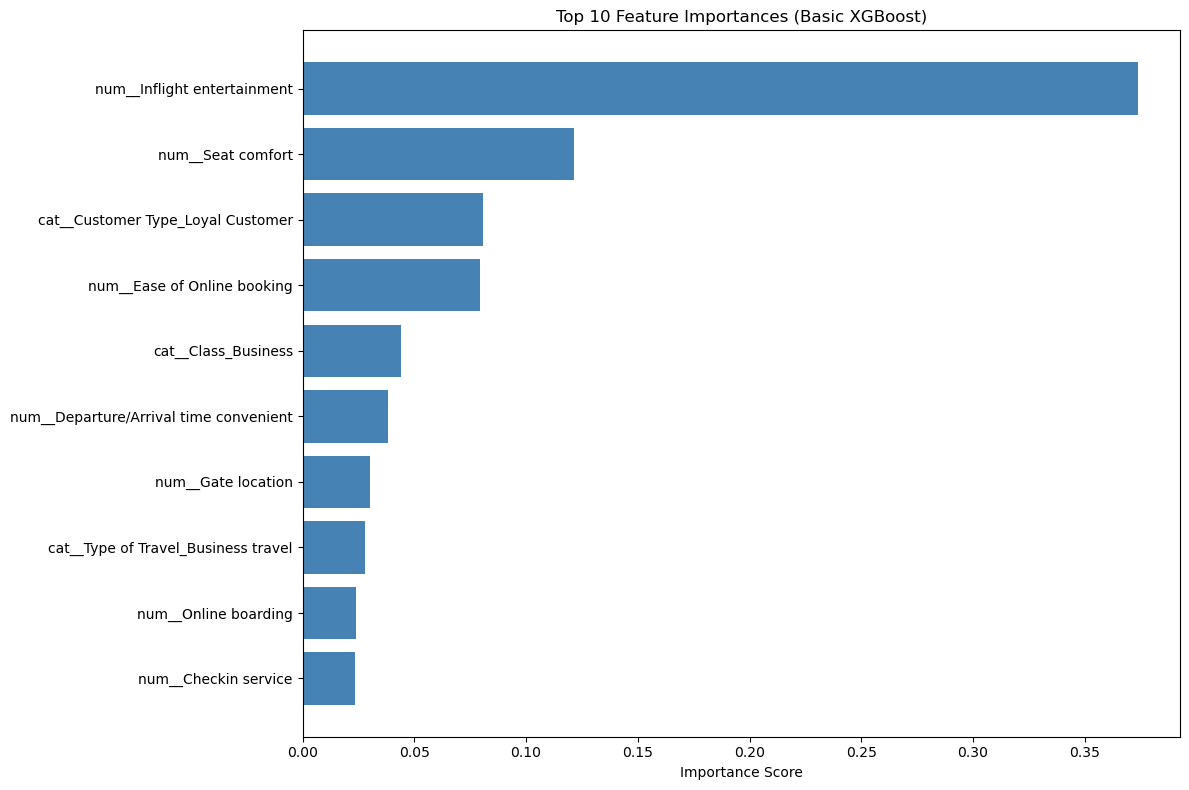

In [13]:
# Plot feature importance
plt.figure(figsize=(12, 8))
top_n = 10
top_features = feature_importance_df.head(top_n)
plt.barh(range(len(top_features)), top_features['Importance'], align='center', color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Feature Importances (Basic XGBoost)')
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()
plt.show()

### HYPERPARAMETER TUNING WITH CROSS-VALIDATION

In [14]:
from sklearn.base import clone 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "random_state": 42,
        "eval_metric": "logloss",
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 100.0, log=True),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
    }

    pipe = Pipeline(steps=[
        ("prep", clone(xgb_preprocessor_cv)),  # clone + unfitted preprocessor for each CV run
        ("clf", xgb.XGBClassifier(**params))
    ])

    scores = cross_val_score(
        pipe,
        X_train_raw,
        y_train_encoded,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1
    )
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("\nBest CV ROC-AUC:", study.best_value)
print("Best params:", study.best_params)

[I 2026-01-08 01:35:02,395] A new study created in memory with name: no-name-4c323ce5-dae5-4aed-af4c-db5a443e1497


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2026-01-08 01:35:23,680] Trial 0 finished with value: 0.9930080597234874 and parameters: {'n_estimators': 553, 'max_depth': 5, 'learning_rate': 0.10149923658482274, 'gamma': 1.2367813650941653, 'subsample': 0.6026408396194184, 'colsample_bytree': 0.7237010029989884, 'reg_lambda': 0.5559713865187008, 'min_child_weight': 2.0702111520289312}. Best is trial 0 with value: 0.9930080597234874.
[I 2026-01-08 01:35:53,907] Trial 1 finished with value: 0.9933456601958415 and parameters: {'n_estimators': 560, 'max_depth': 9, 'learning_rate': 0.05433289888585704, 'gamma': 0.33240672088685175, 'subsample': 0.6147110291665385, 'colsample_bytree': 0.9592022877248043, 'reg_lambda': 4.327871119208561, 'min_child_weight': 8.247805914754696}. Best is trial 1 with value: 0.9933456601958415.
[I 2026-01-08 01:36:14,441] Trial 2 finished with value: 0.9930225401945629 and parameters: {'n_estimators': 586, 'max_depth': 8, 'learning_rate': 0.15066090444056246, 'gamma': 0.5669621325199334, 'subsample': 0.717

In [15]:
# Train final tuned model (pipeline) on full training data
best_params = study.best_params.copy()

final_xgb = Pipeline(steps=[
    ("prep", xgb_preprocessor_cv),  # use unfitted preprocessor
    ("clf", xgb.XGBClassifier(
        objective="binary:logistic",
        random_state=42,
        eval_metric="logloss",
        **best_params
    ))
])

final_xgb.fit(X_train_raw, y_train_encoded)

y_train_pred_final = final_xgb.predict(X_train_raw)
y_test_pred_final  = final_xgb.predict(X_test_raw)

y_train_proba_final = final_xgb.predict_proba(X_train_raw)[:, 1]
y_test_proba_final  = final_xgb.predict_proba(X_test_raw)[:, 1]

train_metrics_final = calculate_metrics(
    y_train_encoded, y_train_pred_final, y_train_proba_final, "Final XGBoost - Train"
)
test_metrics_final = calculate_metrics(
    y_test_encoded, y_test_pred_final, y_test_proba_final, "Final XGBoost - Test"
)


Final XGBoost - Train Performance:
  Accuracy: 0.9857
  Precision: 0.9857
  Recall: 0.9857
  F1-Score: 0.9857
  AUC: 0.9992

Final XGBoost - Test Performance:
  Accuracy: 0.9604
  Precision: 0.9608
  Recall: 0.9604
  F1-Score: 0.9605
  AUC: 0.9944


- StratifiedKFold (5-fold) was defined to ensure that class distributions are preserved in each fold.
- An objective function was created for Optuna optimization.
- The objective function was designed to maximize the cross-validated ROC-AUC score.
- Search spaces for XGBoost hyperparameters to be tuned by Optuna were defined.
- A new Pipeline was constructed for each Optuna trial.
- A cloned and unfitted preprocessor was used within the Pipeline.
- This approach ensures that preprocessing steps are refitted in each CV fold, preventing data leakage and optimistic CV scores.
- The Pipeline was evaluated using cross-validation on the training data only.
- For each trial, the mean ROC-AUC across 5-fold Stratified Cross-Validation was computed.
- Optuna was executed to identify the hyperparameter combination that achieved the highest ROC-AUC.
- A final XGBoost Pipeline was built using the best hyperparameters.
- The final model was retrained on the full training dataset.

### FEATURE IMPORTANCES FOR FINAL MODEL

In [16]:
# Get feature names AFTER preprocessing 
feature_names = final_xgb.named_steps["prep"].get_feature_names_out()

# Get trained XGBoost model from the pipeline
xgb_model = final_xgb.named_steps["clf"]

# Get feature importances
final_importances = xgb_model.feature_importances_

final_feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": final_importances
}).sort_values("Importance", ascending=False)

print("\nTop 10 Most Important Features (Final XGBoost):")
print(final_feature_importance_df.head(10).to_string(index=False))


Top 10 Most Important Features (Final XGBoost):
                               Feature  Importance
           num__Inflight entertainment       0.298
                     num__Seat comfort       0.106
     cat__Customer Type_Loyal Customer       0.093
           num__Ease of Online booking       0.090
  cat__Customer Type_disloyal Customer       0.052
                   num__Online support       0.035
   cat__Type of Travel_Personal Travel       0.030
   cat__Type of Travel_Business travel       0.030
                   cat__Class_Business       0.026
num__Departure/Arrival time convenient       0.024


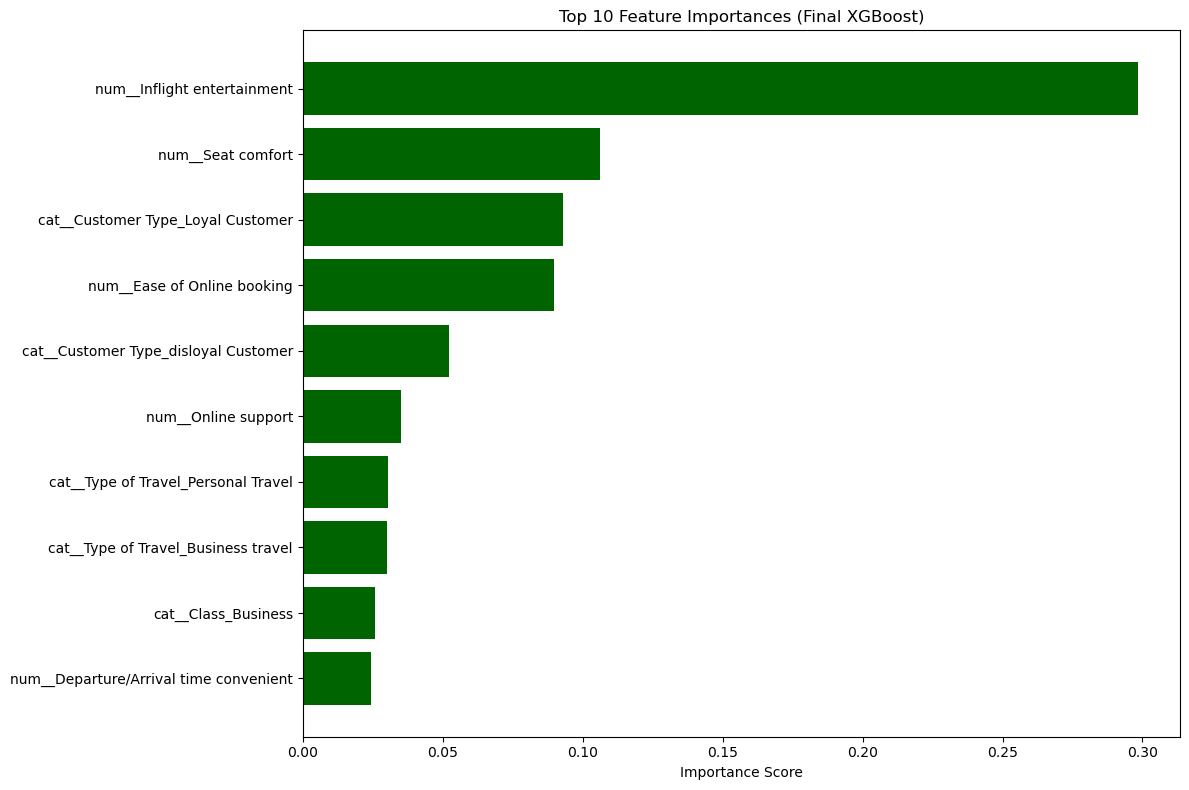

In [17]:
# Plot top 10 feature importances
plt.figure(figsize=(12, 8))
top_n = 10
top_features_final = final_feature_importance_df.head(top_n)
plt.barh(range(len(top_features_final)), top_features_final['Importance'], align='center', color='darkgreen')
plt.yticks(range(len(top_features_final)), top_features_final['Feature'])
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Feature Importances (Final XGBoost)')
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()
plt.show()

In [18]:
# Compare basic vs final feature importances
print("Comparison of Feature Importances (Basic vs Final XGBoost):")
comparison_df = pd.merge(
    feature_importance_df.rename(columns={'Importance': 'Basic_Importance'}),
    final_feature_importance_df.rename(columns={'Importance': 'Final_Importance'}),
    on='Feature'
)
comparison_df['Change'] = comparison_df['Final_Importance'] - comparison_df['Basic_Importance']
print(comparison_df.sort_values('Final_Importance', ascending=False).head(10).to_string(index=False))

Comparison of Feature Importances (Basic vs Final XGBoost):
                               Feature  Basic_Importance  Final_Importance  Change
           num__Inflight entertainment             0.374             0.298  -0.075
                     num__Seat comfort             0.122             0.106  -0.016
     cat__Customer Type_Loyal Customer             0.081             0.093   0.012
           num__Ease of Online booking             0.080             0.090   0.010
  cat__Customer Type_disloyal Customer             0.000             0.052   0.052
                   num__Online support             0.019             0.035   0.016
   cat__Type of Travel_Personal Travel             0.000             0.030   0.030
   cat__Type of Travel_Business travel             0.028             0.030   0.002
                   cat__Class_Business             0.044             0.026  -0.018
num__Departure/Arrival time convenient             0.038             0.024  -0.014


- After tuning, the model is not overloaded with a single feature; its decisions become more spread out and regularized. Therefore, there is a decrease in feature importance.

### COMPREHENSIVE EVALUATION

In [19]:
class_names = le_target.classes_.tolist()

print("Classification Report - Final XGBoost:")
print(
    classification_report(
        y_test_encoded,
        y_test_pred_final,
        target_names=class_names
    )
)

Classification Report - Final XGBoost:
              precision    recall  f1-score   support

dissatisfied       0.95      0.97      0.96     10937
   satisfied       0.97      0.95      0.96     12914

    accuracy                           0.96     23851
   macro avg       0.96      0.96      0.96     23851
weighted avg       0.96      0.96      0.96     23851



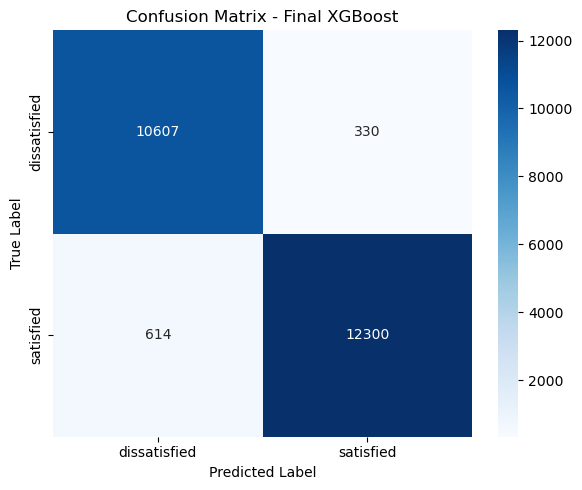

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_test_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Confusion Matrix - Final XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

AUC Score: 0.9944


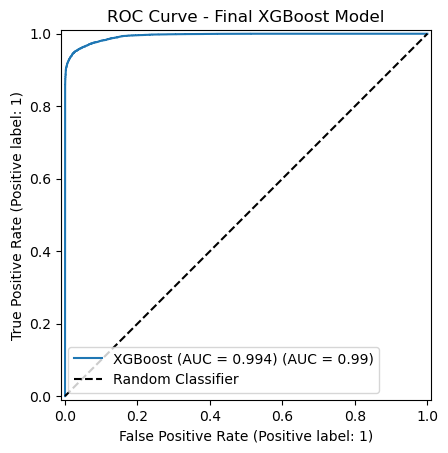

In [21]:
# ROC Curve
if len(class_names) == 2:  # Binary classification
    auc_score = roc_auc_score(y_test_encoded, y_test_proba_final)
    print(f"AUC Score: {auc_score:.4f}")
    
    RocCurveDisplay.from_estimator(
        final_xgb, X_test_raw, y_test_encoded,
        name=f"XGBoost (AUC = {auc_score:.3f})"
    )
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.title('ROC Curve - Final XGBoost Model')
    plt.legend()
    plt.show()

### PERFORMANCE VALIDATION & OVERFITTING DETECTION

XGBoost Overfitting Analysis
------------------------------
Training Accuracy: 0.9857
Testing Accuracy:  0.9604
Difference:        0.0252
------------------------------
Training AUC:      0.9992
Testing AUC:       0.9944
Difference:        0.0048


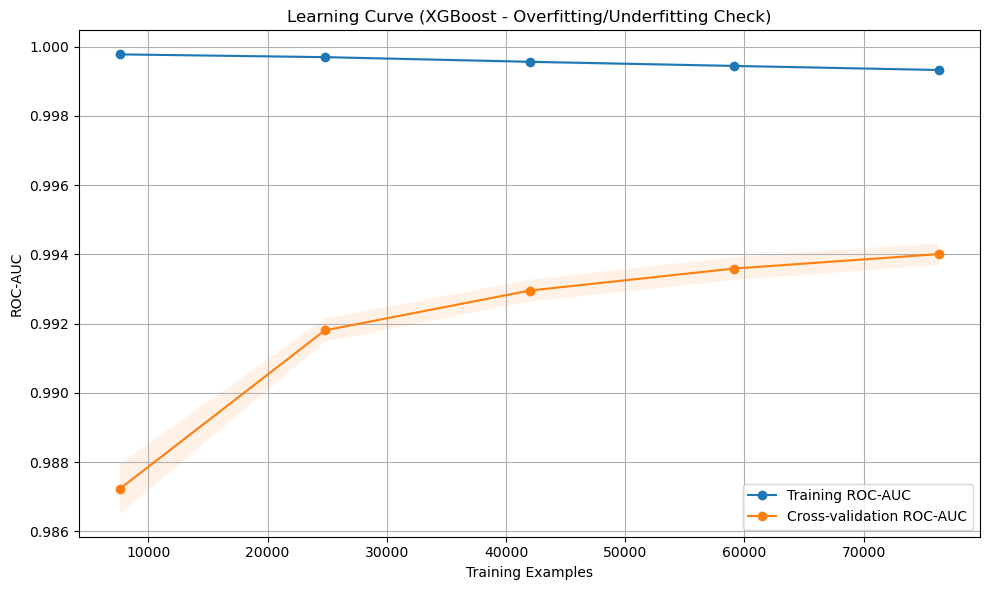

In [22]:
# Generate predictions for both sets 
y_train_pred_xgb = final_xgb.predict(X_train_raw)
y_test_pred_xgb  = final_xgb.predict(X_test_raw)

# Calculate accuracies
train_acc_xgb = accuracy_score(y_train_encoded, y_train_pred_xgb)
test_acc_xgb  = accuracy_score(y_test_encoded, y_test_pred_xgb)

# Calculate AUC
y_train_proba_xgb = final_xgb.predict_proba(X_train_raw)[:, 1]
y_test_proba_xgb  = final_xgb.predict_proba(X_test_raw)[:, 1]

train_auc_xgb = roc_auc_score(y_train_encoded, y_train_proba_xgb)
test_auc_xgb  = roc_auc_score(y_test_encoded, y_test_proba_xgb)

print("XGBoost Overfitting Analysis")
print("-" * 30)
print(f"Training Accuracy: {train_acc_xgb:.4f}")
print(f"Testing Accuracy:  {test_acc_xgb:.4f}")
print(f"Difference:        {abs(train_acc_xgb - test_acc_xgb):.4f}")
print("-" * 30)
print(f"Training AUC:      {train_auc_xgb:.4f}")
print(f"Testing AUC:       {test_auc_xgb:.4f}")
print(f"Difference:        {abs(train_auc_xgb - test_auc_xgb):.4f}")

# Learning Curve 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    estimator=final_xgb,
    X=X_train_raw,                 
    y=y_train_encoded,
    cv=cv,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring="roc_auc"              
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "o-", label="Training ROC-AUC")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)

plt.plot(train_sizes, val_mean, "o-", label="Cross-validation ROC-AUC")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

plt.title("Learning Curve (XGBoost - Overfitting/Underfitting Check)")
plt.xlabel("Training Examples")
plt.ylabel("ROC-AUC")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

- Strong predictive performance: The XGBoost model achieves very high test accuracy (≈0.96) and an excellent ROC-AUC (≈0.99), indicating outstanding ability to distinguish between satisfied and dissatisfied customers.

- Mild but controlled overfitting: Training performance is higher than testing performance, which is expected for a high-capacity model like XGBoost, but the small gap in ROC-AUC shows that overfitting is limited and well managed.

- Stable learning behavior: The learning curve demonstrates that cross-validation performance improves as the training set grows, suggesting that the model generalizes well and continues to benefit from additional data.

### MODEL COMPARISON SUMMARY

In [23]:
# Create comparison summary
comparison_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
    'Train_Basic_XGBoost': [
        train_metrics_basic.get('Accuracy', None),
        train_metrics_basic.get('Precision', None),
        train_metrics_basic.get('Recall', None),
        train_metrics_basic.get('F1-Score', None),
        train_metrics_basic.get('AUC', None)
    ],
    'Test_Basic_XGBoost': [
        test_metrics_basic.get('Accuracy', None),
        test_metrics_basic.get('Precision', None),
        test_metrics_basic.get('Recall', None),
        test_metrics_basic.get('F1-Score', None),
        test_metrics_basic.get('AUC', None)
    ],
    'Train_Final_XGBoost': [
        train_metrics_final.get('Accuracy', None),
        train_metrics_final.get('Precision', None),
        train_metrics_final.get('Recall', None),
        train_metrics_final.get('F1-Score', None),
        train_metrics_final.get('AUC', None)
    ],
    'Test_Final_XGBoost': [
        test_metrics_final.get('Accuracy', None),
        test_metrics_final.get('Precision', None),
        test_metrics_final.get('Recall', None),
        test_metrics_final.get('F1-Score', None),
        test_metrics_final.get('AUC', None)
    ]
})

print("XGBoost Model Comparison Summary:")
print(comparison_summary.to_string(index=False))

XGBoost Model Comparison Summary:
   Metric  Train_Basic_XGBoost  Test_Basic_XGBoost  Train_Final_XGBoost  Test_Final_XGBoost
 Accuracy                0.972               0.957                0.986               0.960
Precision                0.972               0.958                0.986               0.961
   Recall                0.972               0.957                0.986               0.960
 F1-Score                0.972               0.957                0.986               0.960
      AUC                0.997               0.993                0.999               0.994


In [24]:
duplicate_count = airline_data.duplicated().sum()
print(f"Total duplicate row: {duplicate_count}")

Total duplicate row: 0


## Overfitting

- A mild level of overfitting is present; however, it is well controlled.

- The gaps: Are expected and acceptable for powerful and flexible models such as XGBoost.
- Since the model’s discriminative ability remains very high on the test set, there is no evidence of severe memorization.
- Overall, the model:
  - Learns the training data very effectively,
  - While largely preserving its generalization capability.



## Data Leakage

- No evidence of data leakage is observed.
- During preprocessing:
  - One-Hot Encoding is fitted only on the training data.
  - The test data is only transformed, not fitted.
- During cross-validation:
  - An unfitted and cloned preprocessor is used.
  - This ensures preprocessing is refitted within each fold, preventing optimistic CV scores.
- Model evaluation:
  - Cross-validation is performed exclusively on the training data.
  - The test set is used only for a final and independent evaluation.
- The fact that training and testing scores are not identical:
  - Is a natural indication that data leakage is not present.
